In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Reading Datasets
order_df=pd.read_csv("olist_orders_dataset.csv")
order_df.head()

customer_df=pd.read_csv("olist_customers_dataset.csv")

order_review_df=pd.read_csv("olist_order_reviews_dataset.csv")

product_df=pd.read_csv("olist_products_dataset.csv")

order_items_df=pd.read_csv("olist_order_items_dataset.csv")

In [4]:
olist_df1=pd.merge(customer_df,order_df,how="inner",on=['customer_id'])
olist_df1.head()


olist_df2=pd.merge(olist_df1,order_review_df,how="inner",on=['order_id'])
olist_df2.head()

olist_df3=pd.merge(olist_df2,order_items_df,how="inner",on=['order_id'])
olist_df3.head()

olist_df4=pd.merge(olist_df3,product_df,how="inner",on=['product_id'])
olist_df4.head()
print(olist_df4.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')


In [5]:

# Create a final dataframe with only the required attributes

olist_df = olist_df4[['customer_id','customer_unique_id', 'order_id', 'product_id','review_id', 'order_purchase_timestamp', 'customer_city','customer_state' ,'product_category_name','review_score', 'order_item_id', 'review_creation_date', 'price', 'freight_value']]
olist_df.head()
olist_df.shape

(112372, 14)

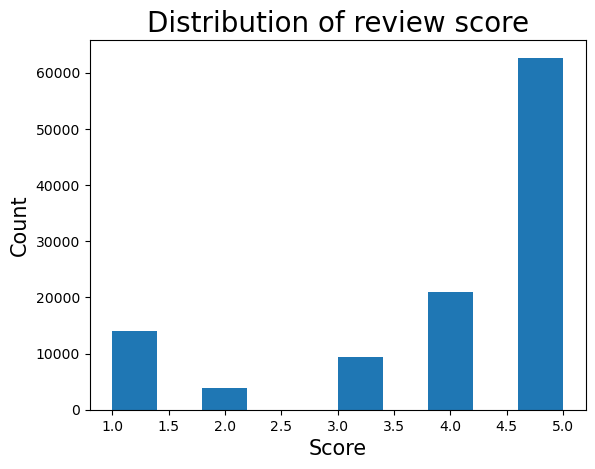

In [6]:
# Obtain the distribution of review score

olist_df=olist_df.dropna()
plt.hist(olist_df.review_score)
plt.xlabel("Score", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of review score", fontsize=20)
plt.show()

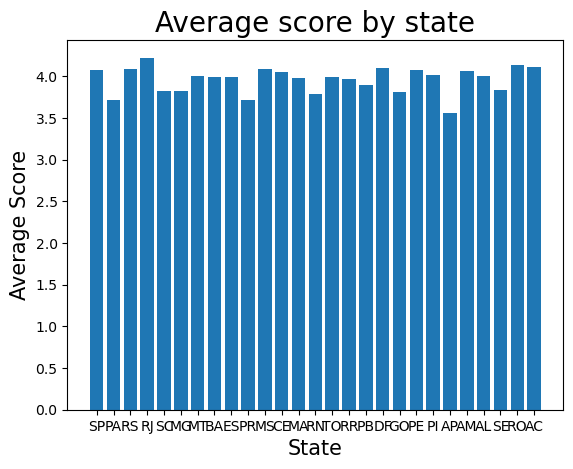

In [7]:
# Obtain distribution of review score by state

x = olist_df.customer_state.unique()
y = olist_df.groupby("customer_state")['review_score'].mean()

plt.bar(x,y)
plt.ylabel("Average Score", fontsize=15)
plt.xlabel("State", fontsize=15)
plt.title("Average score by state", fontsize=20)

plt.show()

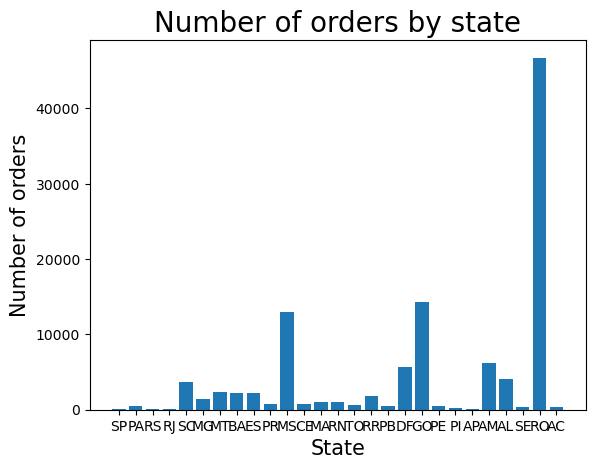

In [8]:
# Obtain count of orders by state

x1 = olist_df.customer_state.unique()
y1 = olist_df.groupby("customer_state")['customer_unique_id'].count()

plt.bar(x1,y1)
plt.xlabel("State", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title("Number of orders by state", fontsize=20)
plt.show()

In [9]:
# Obtain the number of orders placed by every customer
num_of_orders = olist_df[['order_id']].groupby(olist_df['customer_unique_id']).agg({'order_id':'count'})                                    
num_of_orders = num_of_orders.rename(columns = {'order_id': 'order_count'})
num_of_orders = num_of_orders.reset_index()
num_of_orders.order_count.unique

<bound method Series.unique of 0        1
1        1
2        1
3        1
4        1
        ..
93412    2
93413    1
93414    1
93415    1
93416    1
Name: order_count, Length: 93417, dtype: int64>

In [19]:
# Create features data frame with the required features
features = olist_df[[ 'customer_unique_id', 'customer_state','review_score','price', 'freight_value']]
features = pd.merge(features,num_of_orders, how='inner', on=['customer_unique_id'])
features.head()

customer_unique_id customer_state  review_score   price  \
0  861eff4711a542e4b93843c6dd7febb0             SP             4  124.99   
1  9eae34bbd3a474ec5d07949ca7de67c0             PA             1  112.99   
2  9eae34bbd3a474ec5d07949ca7de67c0             PA             1  112.99   
3  3c799d181c34d51f6d44bbbc563024db             RS             3  124.99   
4  23397e992b09769faf5e66f9e171a241             RJ             4  106.99   

   freight_value  order_count  
0          21.88            1  
1          24.90            2  
2          24.90            2  
3          15.62            1  
4          30.59            1

In [11]:

# Select the required features for clustering
features_2 = olist_df[[ 'customer_unique_id','review_score','price', 'freight_value']]
features_2 = pd.merge(features_2,num_of_orders, how='inner', on=['customer_unique_id'])
features_2['Total_Price']=features_2['price']+features_2['freight_value']
features_2.drop_duplicates(inplace=True)
features_2.drop(['price', 'freight_value', 'customer_unique_id'], axis=1, inplace=True)
features_2.head()


review_score  order_count  Total_Price
0             4            1       146.87
1             1            2       137.89
3             3            1       140.61
4             4            1       137.58
5             4            1       142.05

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

In [13]:
# standardize features
scaler = StandardScaler()
x_std=scaler.fit_transform(features_2)
x_std[:5]

array([[-0.06016054, -0.3283534 ,  0.00950992],
       [-2.28420447,  0.7833048 , -0.03654575],
       [-0.80150851, -0.3283534 , -0.0225957 ],
       [-0.06016054, -0.3283534 , -0.03813564],
       [-0.06016054, -0.3283534 , -0.01521038]])

In [16]:
# Determine SSE

sse=[]
for k in range(1,6):
    model=KMeans(n_clusters=k)
    model.fit(x_std)
    sse.append(model.inertia_)


C:\Users\kamal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kamal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kamal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kamal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

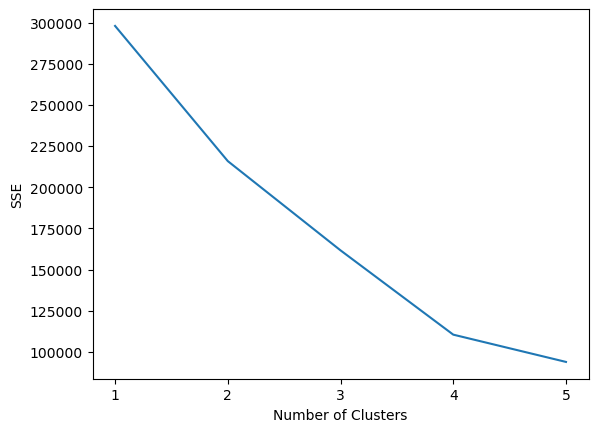

In [17]:
# Plot SSE

plt.plot(range(1, 6), sse)
plt.xticks(range(1, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [18]:
# Determine Silhoutte Score
silhouette_coefficients = []

for k in range(2, 6):
    model = KMeans(n_clusters=k, )
    model.fit(x_std)
    score = silhouette_score(x_std, model.labels_)
    silhouette_coefficients.append(score)

C:\Users\kamal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kamal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kamal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kamal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

In [24]:
print(silhouette_coefficients)

[0.5155375470049549, 0.5450182615380915, 0.5720304725597842, 0.5750544037180074]


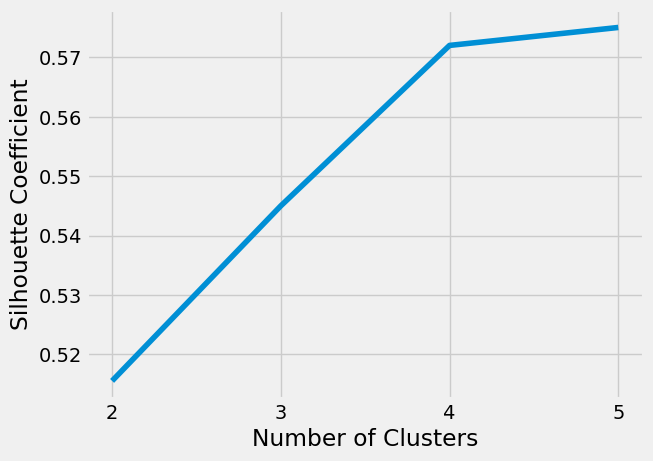

In [19]:
# Plot Silhoutte Coefficient

plt.style.use("fivethirtyeight")
plt.plot(range(2, 6), silhouette_coefficients)
plt.xticks(range(2, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [25]:
# Perform KMeans with optimal number of clusters - 5

cluster=KMeans(n_clusters=5, random_state=0)
model=cluster.fit(x_std)
print("The sse value is:", model.inertia_)
print("\nThe final locations of centroid:", model.cluster_centers_)
print("\nThe number of iterations required to converge:", model.n_iter_)

C:\Users\kamal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The sse value is: 93874.01732228734

The final locations of centroid: [[ 0.04469933 -0.23958982  4.55572405]
 [-1.65297852 -0.00839331 -0.10453403]
 [ 0.49409647 -0.3283534  -0.11295034]
 [-0.35812645  6.00340816 -0.21126   ]
 [ 0.43839314  1.1997883  -0.21284601]]

The number of iterations required to converge: 12


In [33]:
features_2['K_Means']=model.labels_
features_2['Segment'] = features_2['K_Means'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth'})
features_2.head(100)

review_score  order_count  Total_Price  K_Means Segment
0               4            1       146.87        2   third
1               1            2       137.89        1  second
3               3            1       140.61        1  second
4               4            1       137.58        2   third
5               4            1       142.05        2   third
..            ...          ...          ...      ...     ...
119             5            1       159.09        2   third
120             4            1       192.05        2   third
121             4            1       176.15        2   third
122             4            1       184.50        2   third
123             5            1       173.30        2   third

[100 rows x 5 columns]

In [36]:
# Export dataset
features_2.to_csv('Customer segment.csv')

In [25]:
print(features_2.columns)

Index(['review_score', 'order_count', 'Total_Price'], dtype='object')


In [20]:
# Perform PCA and fit the scaled data 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
als_pca=pca.fit_transform(x_std)

In [21]:
# Store the PCA components into a dataframe and classify the segments

pca_als_df=pd.DataFrame(data = als_pca
             , columns = ['principal_component_1', 'principal_component_2'])
pca_als_df['K_Means_PCA'] = model.labels_
pca_als_df['Segment'] = pca_als_df['K_Means_PCA'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth'})
pca_als_df.tail()

principal_component_1  principal_component_2  K_Means_PCA Segment
99317               0.296560               0.309913            4   fifth
99318              -0.015933              -0.459694            1  second
99319              -0.456014               0.752451            1  second
99320              -0.572504              -0.557021            1  second
99321               1.084749               1.399608            4   fifth

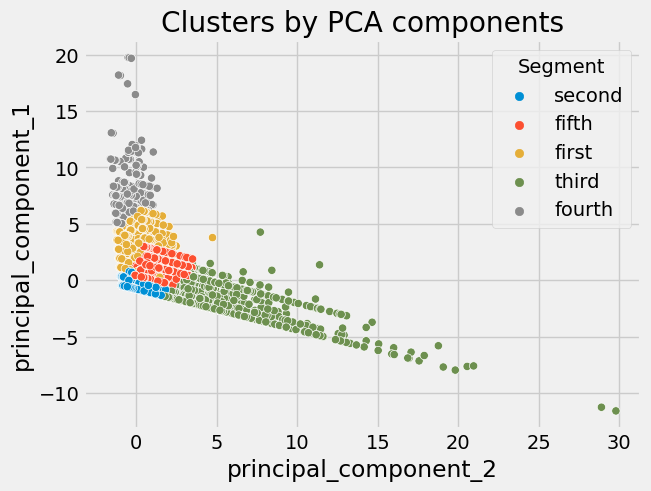

In [22]:
# Plot PCA components -
sns.scatterplot(x=pca_als_df.principal_component_2,y=pca_als_df.principal_component_1, 
                hue =pca_als_df['Segment'])
plt.title('Clusters by PCA components')
plt.show()

In [23]:
# Export dataset
features_2.to_csv('Customer segment.csv')